# Optimization of a circulator layout

Author: Alexis Morvan
Date: 2021-08-24

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("../")

from freq_allocation.yield_mc_simulation import *
from freq_allocation.frequency_graph import FrequencyGraph
from freq_allocation.optimization import layout_optimizer

# silencing pyomo wanring
import logging
import itertools

logging.getLogger('pyomo.core').setLevel(logging.ERROR)

# import pandas as pd

## Definition of the layout
We are defining a circular layout of N-transmons. Here we consider a simple circular layout where the edge goes likes:

0 --> 1 --> 2 --> ... --> N//2 <-- ... <-- N-1 <-- N <-- 0

In [4]:
architecture = "CR"  # choosing the architecture: CZ or CR
cz = True if architecture=='CZ' else False
qutrit = True # qutrit or qubits

# for later:
# thresholds
# weights
all_differents = False
# solver name

#thresholds
if architecture == 'CR':
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "F1", "F2", "M1"]
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cr_keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4","C1", "C1b", "F1", "F2", "M1"]
    cstr_key = cr_keys

#CZ constraints
elif architecture == 'CZ':
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cstr_key = keys

elif (architecture == 'CR') and qutrit:
    d_dict = {'A1': 0.017,
              'A2i': 0.03,
              'A2j': 0.03,
              'A3i': 0.03,
              'A3j': 0.03,
              "E1": 0.017,
              "E2": 0.03,
              "E3": 0.03,
              "E4":0.002,
              "F1": 0.017,
              "F2":0.025,
              "F3": 0.025,
              "M1": 0.017}
    cr_keys = ['A1', 'A2i', 'A2j','A3i', 'A3j', "E1", "E2","E3", "E4",
               "C1", "C1b", "F1", "F2","F3",  "M1"]
    cstr_key = cr_keys
    
    
    
# free of drive
# keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
# d = np.array([0.017, 0.03 , 0.03 , 0.00, 0.00 , 0.000, 0.00, 0.00 , 0.000, 0.00, 0.00, 0.00])
# d_dict = { k: dd for (k, dd) in zip(keys, d)}
# cstr_key = keys

# constructing the lattice
To construct the lattice, I am using the very neat features of pybinding package. In future, it might be worth having the pybinding code directly inside the codebase

In [5]:
import pybinding as pb


def hexagon_lattice_6():

    d = 1  # placeholder
    t = 1    # placeholder

    # create a simple 2D lattice with vectors a1 and a2
    lattice = pb.Lattice(a1=[6, 2], a2=[0, 4])
    
    nodes = [(f"A_{i}_{j}", [i, j]) for (i, j) in itertools.product(range(6),range(3))]
    for i in [1, 2, 3, 5]:
        nodes.remove((f"A_{i}_{1}", [i, 1]))
    nodes.append((f"A_{2}_{3}", [2, 3]))
    lattice.add_sublattices( *nodes)

    # add the hopping for the internal sub-lattice
    lattice.add_hoppings(((0, 0), "A_1_0", "A_0_0", t),
                         ((0, 0), "A_1_0", "A_2_0", t),
                         ((0, 0), "A_3_0", "A_2_0", t),
                         ((0, 0), "A_3_0", "A_4_0", t),
                         ((0, 0), "A_1_2", "A_0_2", t),
                         ((0, 0), "A_1_2", "A_2_2", t),
                         ((0, 0), "A_3_2", "A_2_2", t),
                         ((0, 0), "A_3_2", "A_4_2", t),
                         ((0, 0), "A_0_1", "A_0_0", t),
                         ((0, 0), "A_0_1", "A_0_2", t),
                         ((0, 0), "A_4_1", "A_4_0", t),
                         ((0, 0), "A_4_1", "A_4_2", t),
                         ((0, 0), "A_2_3", "A_2_2", t),
                         ((0, 0), "A_5_0", "A_4_0", t),
                         ((0, 0), "A_5_2", "A_4_2", t),
    )


#     # now the link between subregions
    lattice.add_hoppings(([0, 1], f'A_2_3', f'A_2_0', t),
                         ([1, -1], "A_5_0", "A_0_2", t),
                         ([1, 0], "A_5_2", "A_0_0", t),
#                          ([1, -1], "A_2_0", "A_0_1", t)
    )

    
    return lattice

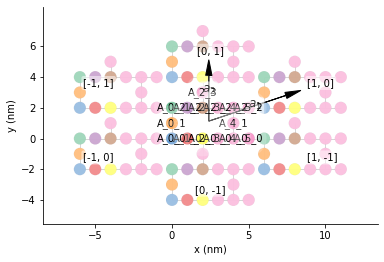

In [6]:
lattice = hexagon_lattice_6()
lattice.plot()  # plot the lattice that was just constructed
plt.show()      # standard matplotlib show() function

## Small model that we will solve

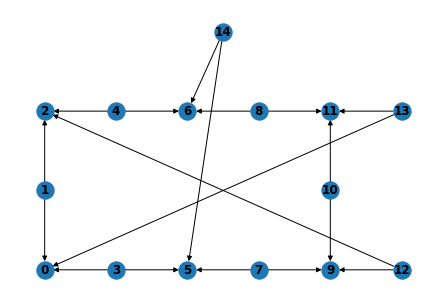

In [7]:
# n = 4

# lattice = square_lattice(n)
edges = [(y.from_id, y.to_id) for y in lattice.hoppings['__anonymous__0'].terms]
pos = {y.unique_id: y.position[:2] for y in lattice.sublattices.values()}  # only taking 2D
pos[14] = [2.5,3] 
# define the frequency graph
G = FrequencyGraph(edges=edges, cz=cz)

# plot if needed
G.plot(pos=pos)

In [8]:
pos[14]

[2.5, 3]

## Solving the small lattice

In [10]:
optimizer = layout_optimizer(graph=G,
                             architecture=architecture,
                             all_differents=all_differents)

In [11]:
# perform the optimization
optimizer.declare_solver()
result = optimizer.first_pass()
print("first pass done")
result = optimizer.second_pass()
print("second pass done")
result = optimizer.third_pass()
print("third pass done")

first pass done
second pass done
third pass done


In [12]:
freqs, anharms, drives = optimizer.get_solution()
G.set_values(freqs, anharms, drives)
print(G.check_solution(d_dict, cstr=cstr_key))

The drive frequency are CR compatible
11 11 11
True


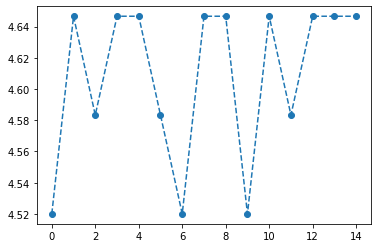

In [13]:
fig, ax = plt.subplots()
ax.plot(G.freqs, 'o--')

19 19 19
Qubit collisions:
yield   = 0.867323
average = 0.238101


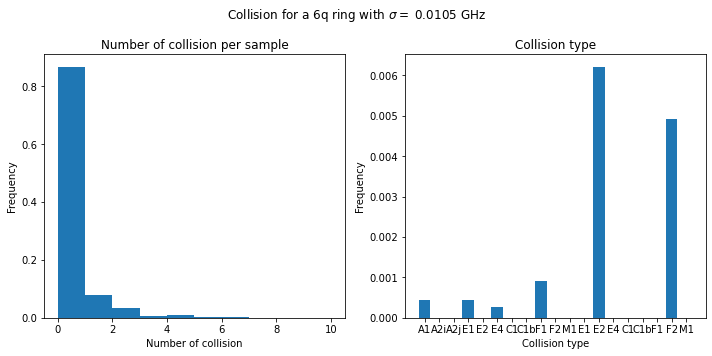

In [29]:
# parametrization
Nsamples = 1e6
sigma = 0.0105

# Calculating yield
collisions, c, idx_list, constraints = G.get_collision(d_dict, sigma=sigma, qutrit=True, cstr=cstr_key, Nsamples=Nsamples)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")


###### plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)

#legend
ax.set_xlabel("Number of collision")
ax.set_ylabel("Frequency")
ax.set_title("Number of collision per sample")

## histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(constraints)

# legend and labels
ax.set_xlabel('Collision type')
ax.set_ylabel('Frequency')
ax.set_title("Collision type")
fig.suptitle(f"Collision for a 6q ring with $\sigma=$ {sigma} GHz")

fig.tight_layout()

19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19


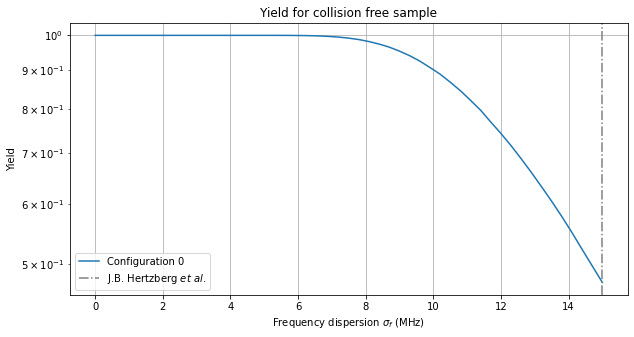

In [32]:

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

# N_samples
Nsamples = 1e6

# varying the dispersion of the frequency
s_vec = np.linspace(0, 0.015, 51)

# saving the results
collisions = np.array([G.get_collision(d_dict, Nsamples=Nsamples, sigma=s, qutrit=True, cstr=cstr_key)[0] for s in s_vec])

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

ax.plot(s_vec*1e3, y[0], label=f'Configuration {0}')


ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

# ax.set_xlim(0, 100)
ax.grid()

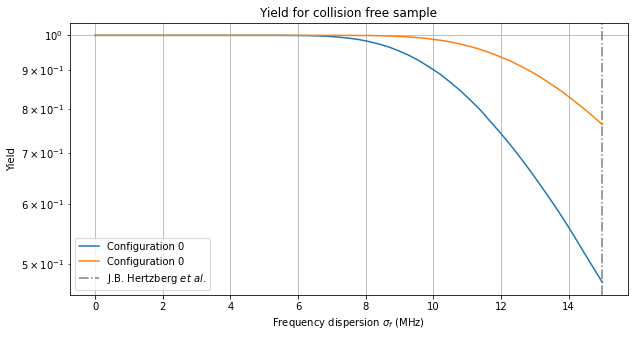

In [33]:

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

ax.plot(s_vec*1e3, y[0], label=f'Configuration {0}')
ax.plot(s_vec*1e3, data, label=f'Configuration {0}')

ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

# ax.set_xlim(0, 100)
ax.grid()

In [31]:
data = y[0]

## Tiling

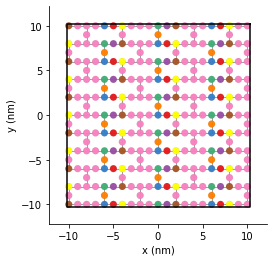

In [66]:
def rectangle(width, height):
    x0 = width / 2
    y0 = height / 2
    return pb.Polygon([[x0, y0], [x0, -y0], [-x0, -y0], [-x0, y0]])

shape = rectangle(width=20.5, height=20.5)

model = pb.Model(lattice, shape)
model.plot()
shape.plot()

In [67]:
def construct_tiling(G, model):

    freqs = {}
    anharms = {}
    drives = {}

    N = model.system.num_sites

    for node in range(N):

        # node values: frequencies and anharmonicity
        # # tge sublattice directly map to the node number of the Graph Frequency
        sublat = model.system.sublattices[node]
        freqs[node] = G.freqs[sublat]
        anharms[node] = G.anharmonicity[sublat]

        # now the edges:
        hop = model.system.hoppings.tocoo()
        edges = list(zip(hop.row, hop.col))

        for e in edges:
            e_sublat = tuple(model.system.sublattices[ee] for ee in e)
            drives[e] = G.drive[e_sublat]

    pos = {i: (model.system.x[i], model.system.y[i]) for i in range(N)}  # only taking 2D
    
    return freqs, anharms, edges, drives, pos

## Tiling of the large latice

In [68]:
freqs, anharms, edges, drives, pos = construct_tiling(G, model)

G2 = FrequencyGraph(edges=edges, cz=cz)
G2.set_values(freqs, anharms, drives)

The drive frequency are CR compatible


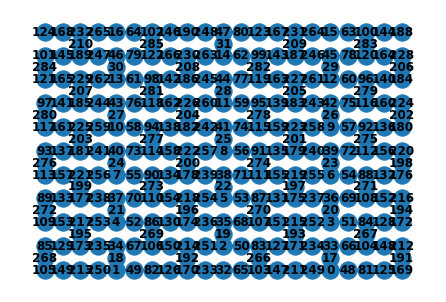

In [69]:
G2.plot(pos=pos)

In [70]:
# saving the results
collisions = np.array([G2.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key)[0] for s in s_vec])

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-nn, axis=1))/Nsamples for nn in n_collisions]

No handles with labels found to put in legend.


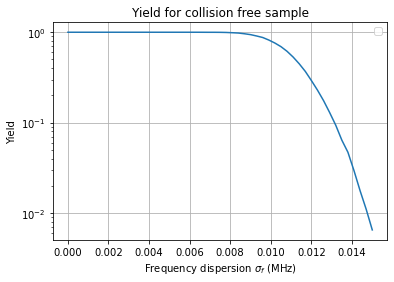

In [71]:
fig, ax = plt.subplots()
ax.plot(s_vec, y[0])

ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

# ax.set_xlim(0, 100)
ax.grid()

# Looping through lattice size of the cell

In [33]:
n_vec = np.arange(4, 20, 2)

# N_samples
Nsamples = 1000

# varying the dispersion of the frequency
s_vec = list(np.linspace(0, 0.008, 21))
s_vec = np.array(s_vec)

data = np.zeros((len(n_vec), len(s_vec)))
window = np.zeros((len(n_vec)))

for i_n, n in enumerate(n_vec):
    
    print(f"cell size = {n}")
    
    # constructing the lattice
    lattice = square_lattice(n)
    edges = [(y.from_id, y.to_id) for y in lattice.hoppings['__anonymous__0'].terms]
    pos = {y.unique_id: y.position[:2] for y in lattice.sublattices.values()}  # only taking 2D

    # define the frequency graph
    G = FrequencyGraph(edges=edges, cz=cz)

    optimizer = layout_optimizer(graph=G,
                                 architecture=architecture,
                                 qutrit=qutrit,
                                 all_differents=all_differents)

    # perform the optimization
    optimizer.declare_solver()
    result = optimizer.first_pass()
    print("first pass successfull")
    optimizer.second_pass()
    print("second pass successfull")
#     result = optimizer.third_pass()
#     print("third pass successfull")
    
    # setting the frequencies
    freqs, anharms, drives = optimizer.get_solution()
    G.set_values(freqs, anharms, drives)
    print(G.check_solution(d_dict, cstr=cstr_key))
    
    # calculate the window
    window[i_n] = max((list(freqs.values()))) - min(list(freqs.values()))
    
    # constructing the finite size large lattice
    shape = rectangle(width=10.5, height=10.5)
    model = pb.Model(lattice, shape)
    
    
    # frequency and anharmonicity are like the cell one, but with modulo
    freqs, anharms, edges, drives, pos = construct_tiling(G, model)

    G2 = FrequencyGraph(edges=edges, cz=cz)
    G2.set_values(freqs, anharms, drives)
    
    # saving the results
    collisions = np.array([G2.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key)[0] for s in s_vec])

    n_collisions = [0]
    y = [(Nsamples-np.count_nonzero(collisions-nn, axis=1))/Nsamples for nn in n_collisions]
    data[i_n, :] = y[0]

cell size = 4
first pass successfull
second pass successfull
The drive frequency are CR compatible
True
The drive frequency are CR compatible
cell size = 6
first pass successfull
second pass successfull
The drive frequency are CR compatible
True
The drive frequency are CR compatible
cell size = 8
first pass successfull
second pass successfull
The drive frequency are CR compatible
True
The drive frequency are CR compatible
cell size = 10
first pass successfull
second pass successfull
The drive frequency are CR compatible
True
The drive frequency are CR compatible
cell size = 12
first pass successfull
second pass successfull
The drive frequency are CR compatible
True
The drive frequency are CR compatible
cell size = 14
first pass successfull
second pass successfull
The drive frequency are CR compatible
True
The drive frequency are CR compatible
cell size = 16
first pass successfull
second pass successfull
The drive frequency are CR compatible
True
The drive frequency are CR compatible
ce

In [34]:
from matplotlib import cm

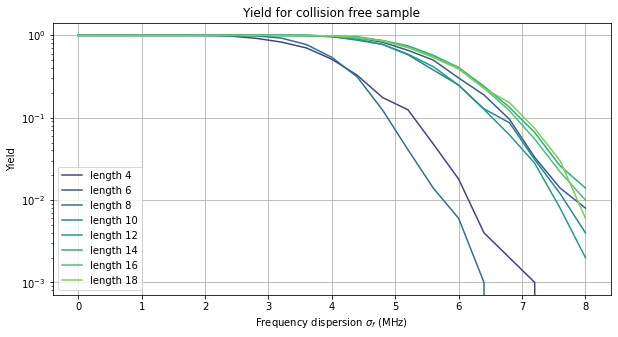

In [35]:
# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

colors = cm.viridis(np.linspace(0.2, 0.8, len(n_vec)))

for k, (n, y) in enumerate(zip(n_vec, data)):
    ax.plot(s_vec*1e3, y, label=f'length {n}', color = colors[k])

# ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")
    
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

# ax.set_xlim(0, 100)
ax.grid()

In [36]:
res = np.zeros(len(n_vec))
for k in range(len(n_vec)):
    res[k] = None
    for i in range(len(s_vec)):
        if np.abs(data[k, i]-1)<1e-1:
            res[k] = i

In [37]:
data

array([[1.   , 1.   , 1.   , 1.   , 1.   , 0.998, 0.98 , 0.922, 0.83 ,
        0.703, 0.513, 0.328, 0.176, 0.125, 0.048, 0.018, 0.004, 0.002,
        0.001, 0.   , 0.   ],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 0.975, 0.937, 0.825, 0.659, 0.501, 0.304, 0.189, 0.096,
        0.033, 0.014, 0.008],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.987, 0.928,
        0.773, 0.541, 0.313, 0.124, 0.041, 0.014, 0.006, 0.001, 0.   ,
        0.   , 0.   , 0.   ],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.999,
        0.996, 0.966, 0.874, 0.775, 0.582, 0.38 , 0.249, 0.128, 0.087,
        0.031, 0.012, 0.004],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.997,
        0.992, 0.961, 0.899, 0.778, 0.591, 0.417, 0.248, 0.126, 0.062,
        0.028, 0.008, 0.002],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        0.997, 0.98 , 0.962, 0.865, 0.748, 0.573, 0.407, 0.241, 0.134

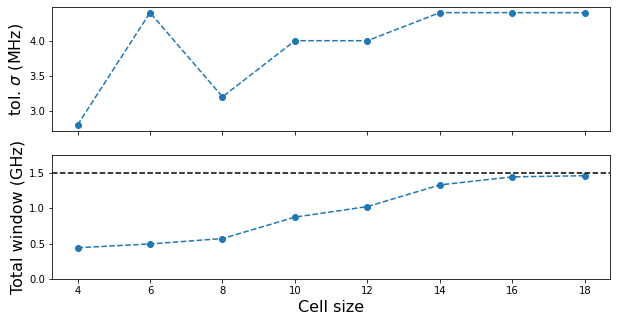

In [38]:
fig, ax = plt.subplots(2, sharex=True,  figsize=(10, 5))

ax[0].plot(n_vec, np.array([s_vec[int(r)] for r in res])*1e3, 'o--')
ax[1].plot(n_vec, window, 'o--')

ax[1].set_xlabel("Cell size", fontsize=16)
ax[0].set_ylabel("tol. $\sigma$ (MHz)", fontsize=16)
ax[1].set_ylabel("Total window (GHz)", fontsize=16)
# ax[0].set_ylim(0, 16)
ax[1].set_ylim(0, 1.75)

ax[1].axhline(1.5, color='k', ls='--')

# ax[0].set_ylim(10, 12)
fig.savefig("scaling_ring.pdf")

In [170]:
n_vec

array([ 4,  8, 12, 16, 20, 24])

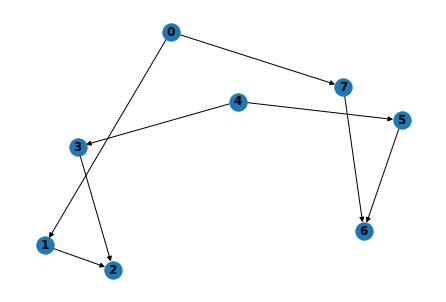

In [58]:
G2 = FrequencyGraph(edges=edges, cz=cz)
G2.plot()

In [85]:
# # manually adding the frequencyes and the drives 
freqs = {k: G.freqs[k] for k in range(4)}
anharms = {k: G.anharmonicity[k] for k in range(4)} 
drives =  {e: freqs[e[1]] for e in G.edges}

In [86]:
for k in range(4):
    freqs[k+4] = freqs[k]

In [87]:
for k in range(4):
    anharms[k+4] = anharms[k]

In [88]:
exceptional_edge = (0,3)

# add the new edges:
from copy import deepcopy
new_drives = deepcopy(drives)
for k in drives.keys():
    if k not in exceptional_edge:
        i, j = k
        new_drives[( (i+4)%8, (j+4)%8)] = drives[(i, j)]    
# change the 0 of the (0,3) edge
new_drives[(4,3)] = drives[(0, 3)]
new_drives[(0,7)] = drives[(0, 3)]
new_drives.pop((0,3), None)
new_drives.pop((4,7), None)

4.575

In [89]:
new_drives

{(0, 1): 4.63,
 (1, 2): 4.52,
 (3, 2): 4.52,
 (4, 5): 4.63,
 (5, 6): 4.52,
 (7, 6): 4.52,
 (4, 3): 4.575,
 (0, 7): 4.575}

In [93]:
drives

{(0, 1): 4.63, (0, 3): 4.575, (1, 2): 4.52, (3, 2): 4.52}

The drive frequency are CR compatible
True


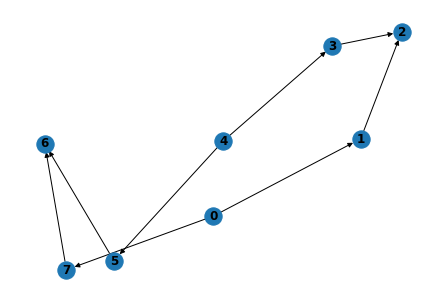

In [95]:
G2 = FrequencyGraph(edges=list(new_drives.keys()), cz=cz)
G2.plot()
G2.set_values(freqs, anharms, new_drives)
print(G2.check_solution(d_dict, cstr=cstr_key))

Qubit collisions:
yield   = 0.06132
average = 4.01872


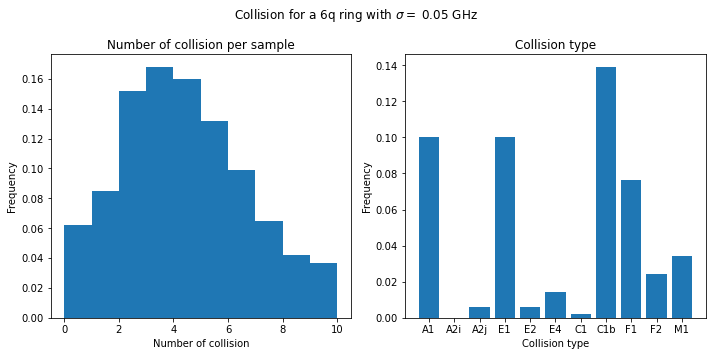

In [96]:
# parametrization
Nsamples = 50000
sigma = 0.05

# Calculating yield
collisions, c, idx_list, constraints = G2.get_collision(d_dict, sigma=sigma, qutrit=False, cstr=cstr_key, Nsamples=Nsamples)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")


###### plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)

#legend
ax.set_xlabel("Number of collision")
ax.set_ylabel("Frequency")
ax.set_title("Number of collision per sample")

## histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(cstr_key)

# legend and labels
ax.set_xlabel('Collision type')
ax.set_ylabel('Frequency')
ax.set_title("Collision type")
fig.suptitle(f"Collision for a 6q ring with $\sigma=$ {sigma} GHz")

fig.tight_layout()

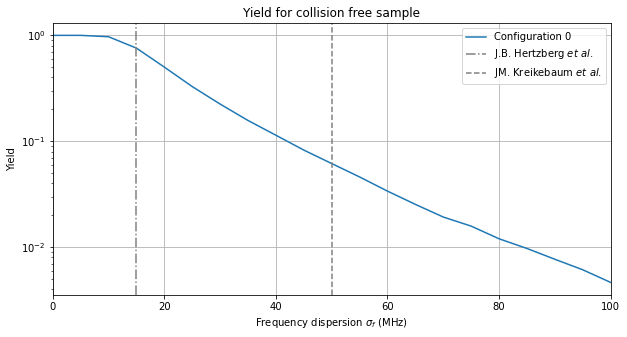

In [102]:
# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

# N_samples
Nsamples = 100000

# varying the dispersion of the frequency
s_vec = np.linspace(0, 0.1, 21)

# saving the results
collisions = np.array([G2.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key)[0] for s in s_vec])

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

ax.plot(s_vec*1e3, y[0], label=f'Configuration {0}')


ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

ax.set_xlim(0, 100)
ax.grid()

In [103]:
data = {"sigma": s_vec, 
        "collisions": collisions,
        "key": cstr_key,
        "yield": y,
        "samples":Nsamples}
np.save(f'ring_8t_{architecture}_yield_2x4.npy',data)

In [104]:
data_CR = np.load('ring_8t_CR_yield.npy', allow_pickle=True)[()]

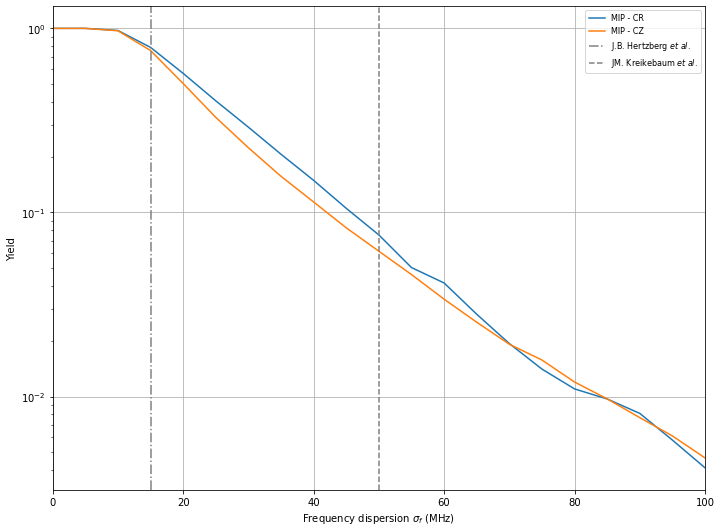

In [105]:
fig, ax = plt.subplots(figsize=(3*3.375, 3*2.5))


s_vec_cr = data_CR["sigma"]
y_cr = data_CR["yield"]

s_vec_cz = data["sigma"]
y_cz = data["yield"]



ax.plot(s_vec_cr*1e3, y_cr[0], label=f'MIP - CR')
ax.plot(s_vec_cz*1e3, y_cz[0], label=f'MIP - CZ')

ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
# ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=8, loc=0)

ax.set_xlim(0, 100)
ax.grid()

fig.tight_layout()

# fig.savefig("fig_yield_ring.pdf")

In [152]:
G.nodes['A'] = 'C'

TypeError: 'NodeView' object does not support item assignment

In [ ]:
fig, ax = plt.subplots()
c = [2, 3, 4]
s = [4]